# Data Processing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import winsound
winsound.Beep(2500, 1550)

## Data directory structure

In [20]:
tree_structure =  !tree data /a
print(*tree_structure[2:], sep='\n')

F:\KOREPETYCJE\BARTOSZ DOROBEK\NEUTRAL_NETWORK_INTRO\DATA
\---gtzan
    +---genres_original
    |   +---blues
    |   +---classical
    |   +---country
    |   +---disco
    |   +---hiphop
    |   +---jazz
    |   +---metal
    |   +---pop
    |   +---reggae
    |   \---rock
    \---images_original
        +---blues
        +---classical
        +---country
        +---disco
        +---hiphop
        +---jazz
        +---metal
        +---pop
        +---reggae
        \---rock


In [5]:
from pathlib import Path
import os

DATA_PATH = Path("data/gtzan/images_original")
print(os.listdir(DATA_PATH))

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Create dataset generator

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32  # 240s=4min per epoch
target_size=(288, 432)
validation_split=0.3

train_datagen = ImageDataGenerator(
    rescale=1./255,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
    validation_split=validation_split,
)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

raw_train_generator = train_datagen.flow_from_directory(DATA_PATH, target_size=target_size, batch_size=batch_size, subset='training')
raw_test_generator = test_datagen.flow_from_directory(DATA_PATH, target_size=target_size, batch_size=batch_size, subset='validation', shuffle=False)

def crop_generator(batches, l, t, r, b):
    while True:
        batch_x, batch_y = next(batches)
        yield (batch_x[:, t:b, l:r], batch_y)
        
train_samples_number = raw_train_generator.samples
test_samples_number = raw_test_generator.samples
train_generator = crop_generator(raw_train_generator, l=54, t=35, r=389, b=253)
test_generator = crop_generator(raw_test_generator, l=54, t=35, r=389, b=253)

Found 700 images belonging to 10 classes.
Found 299 images belonging to 10 classes.


## Data Visualization

image shape: (218, 335, 3)
26.74 MB


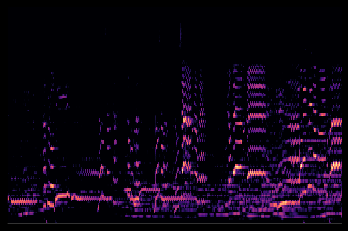

In [37]:
import os, random
from keras.preprocessing import image
import matplotlib.pyplot as plt

sample_train_batch = train_generator.__next__()
image_shape = sample_train_batch[0].shape[1:]
print(f"image shape: {image_shape}")
print(f"{round(sample_train_batch[0].nbytes/(1024*1024),2)} MB")

plt.style.use("dark_background")
randidx = random.randint(0, batch_size-1)
img = sample_train_batch[0][randidx]
imgplot = plt.imshow(img)
plt.axis('off');
plt.show()

# Model Training

## Transfer Learning

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

### DenseNet121

In [4]:
densenet121 = DenseNet121(
    include_top=False,
    weights="imagenet",
    classes=10,
)

for layer in densenet121.layers:
    layer.trainable = False
# densenet121.summary()

gavgp = GlobalAveragePooling2D()(densenet121.output)
drop = Dropout(0.25)(gavgp)
dense = Dense(256 , activation='relu')(drop)
dnn = Dense(10 , activation='softmax')(dense)
model = Model(inputs=densenet121.inputs, outputs=dnn)

### VGG16

In [11]:
# from keras.applications.vgg16 import VGG16
# vgg16 = VGG16(include_top=False, input_shape=image_shape)
# for layer in vgg16.layers:
#     layer.trainable = False
# vgg16.summary()

# flat1 = Flatten()(vgg16.layers[-1].output)
# dense1 = Dense(256 , activation='relu')(flat1)
# dnn = Dense(10, activation='softmax')(dense1)
# model = Model(inputs=vgg16.inputs, outputs=dnn)

## Compile model

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Callbacks

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard

earlystopping = EarlyStopping(
    monitor ="val_loss", 
    patience = 20, 
    restore_best_weights = True
)

model_checkpoint = ModelCheckpoint(
    "models/best_model.hdf5", 
    monitor='val_loss',
    verbose=0, 
    save_best_only=True,
    mode='auto', 
    save_freq='epoch'
)

csv_logger = CSVLogger(
  'logs/history.csv', 
  separator=',', 
  append = False
)

tensorboard = TensorBoard(log_dir='logs')

## Model Fitting

In [15]:
history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=train_samples_number//batch_size,
    validation_data=test_generator,
    validation_steps=test_samples_number//batch_size,
    callbacks=[earlystopping, model_checkpoint, csv_logger, tensorboard]
)

Epoch 1/100
21/21 [==============================] - 34s 826ms/step - loss: 1.9781 - accuracy: 0.2994 - val_loss: 1.5481 - val_accuracy: 0.4688
Epoch 2/100
21/21 [==============================] - 11s 542ms/step - loss: 1.5069 - accuracy: 0.4702 - val_loss: 1.3637 - val_accuracy: 0.5208
Epoch 3/100
21/21 [==============================] - 11s 540ms/step - loss: 1.3343 - accuracy: 0.5479 - val_loss: 1.2637 - val_accuracy: 0.5451
Epoch 4/100
21/21 [==============================] - 11s 525ms/step - loss: 1.2379 - accuracy: 0.5853 - val_loss: 1.2387 - val_accuracy: 0.5833
Epoch 5/100
21/21 [==============================] - 9s 451ms/step - loss: 1.1455 - accuracy: 0.6168 - val_loss: 1.3050 - val_accuracy: 0.5278
Epoch 6/100
21/21 [==============================] - 10s 476ms/step - loss: 1.0951 - accuracy: 0.6138 - val_loss: 1.1541 - val_accuracy: 0.5833
Epoch 7/100
21/21 [==============================] - 11s 516ms/step - loss: 1.0046 - accuracy: 0.6452 - val_loss: 1.1482 - val_accuracy: 

In [16]:
winsound.Beep(2500, 1000)

## Plot training results

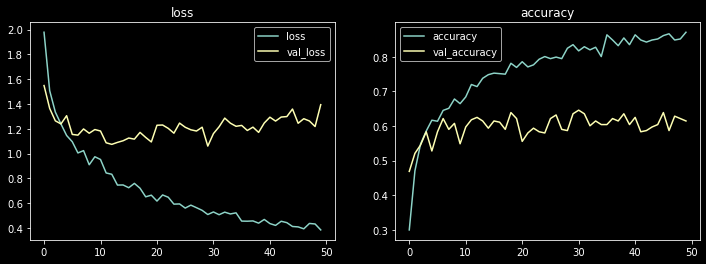

In [17]:
import pandas as pd
results = pd.DataFrame(history.history)
fig, axs = plt.subplots(1, 2, figsize=(12,4))
results[['loss', 'val_loss']].plot(title='loss', ax=axs[0])
results[['accuracy', 'val_accuracy']].plot(title='accuracy', ax=axs[1])
plt.show()

# Evaluate model

## Load model from disc

In [2]:
from keras.models import load_model
loaded_model = load_model('models/best_model.hdf5')
# loaded_model.summary()

## Accuracy

In [3]:
evaluation = loaded_model.evaluate(test_generator, steps=test_samples_number//batch_size)
print(f"Accuracy on test set: {round(100*evaluation[1],2)}%")

NameError: name 'test_generator' is not defined

In [ ]:
total = 0
guessed = 0
fig, axs = plt.subplots(4, 8, figsize=(16,8))
i = 0

for axs_row in axs:
    for ax in axs_row:
        sample_test_batch = test_generator.__next__()
        img = sample_train_batch[0][2]
        imgplot = ax.imshow(img)
        true_label = sample_test_batch[1][2].argmax()
        pred_label = loaded_model.predict(img.reshape(1, *img.shape)).argmax()
        ax.set_title(f"T{true_label} P{pred_label}", c='r' if true_label!=pred_label else 'w')
        ax.axis('off')
        total += 1
        if true_label==pred_label:
            guessed += 1
        i += 1
plt.show()
print(f"Guessed: {guessed}/{total} = {round(100*guessed/total)}%")

## Confusion matrix

In [66]:
prediction = loaded_model.predict(test_generator, steps=test_samples_number/batch_size)
predicted_test_labels = prediction.argmax(axis=1)
true_test_labels = raw_test_generator.classes

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_test_labels, predicted_test_labels, labels=list(raw_test_generator.class_indices.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=raw_test_generator.class_indices)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

NameError: name 'true_test_labels' is not defined

## Recall Precision F1

In [40]:
from sklearn.metrics import recall_score, precision_score, f1_score

recall_val = recall_score(true_test_labels, predicted_test_labels, average='macro')
precision_val = precision_score(true_test_labels, predicted_test_labels, average='macro')
f1_val = f1_score(true_test_labels, predicted_test_labels, average='macro')
print(f"Recall: {round(100*recall_val,2)}%")
print(f"Precission: {round(100*precision_val, 2)}%")
print(f"F1: {round(100*f1_val, 2)}%")

Recall: 63.61%
Precission: 62.35%
F1: 62.14%


# Kill Notebook and clean GPU

## nvidia-smi

In [5]:
import numpy as np
import pandas as pd
gpu_processes = !nvidia-smi
gpu_processes = pd.Series(gpu_processes)
gpu_processes = gpu_processes[gpu_processes.str.contains('python.exe')]
pid2kill = gpu_processes.apply(lambda x: x.split('C')[0].split('N/A')[-1].strip()).to_list()
print(*gpu_processes.values, *pid2kill)

|    0   N/A  N/A      2076      C   ...conda3\envs\ds\python.exe    N/A      | 2076


Expect something like:
    
```
|  0   N/A  N/A  12476  C ...conda3\envs\ds\python.exe N/A | 12476
```

## taskkill (!!! this will kill processes, be extra careful !!!)

In [ ]:
# for pid in pid2kill:
#     !taskkill /F /PID {pid}